## Neural network 의 성능 고도화

이전에 MLP 의 기본적인 backbone 을 구현했다면, 이번에는 딥러닝 성능을 고도화 방법을 구현해본다.

### Content
0. Setting
    - 환경변수
    - MNIST Dataset
1. Dropout
2. Batch Norimlization
3. Optimizers
    - SGD
    - Momentum
    - Nesterov
    - AdaGrad
    - RMSProp
    - Adam

In [7]:
import os
import sys
import random
import platform
import warnings
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import OrderedDict
from nn_mnist import *

#### 0-1. 환경변수

In [2]:
# 재현성을 위해 랜덤 시드를 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"Python Version: {platform.python_version()}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨지는 현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Windows
Python Version: 3.11.5


#### 0-2. MNIST Dataset

In [3]:
mnist = MNIST()
# MNIST 데이터셋 다운로드
mnist.download_dataset()

# MNIST 데이터셋 불러오기
mnist.load_mnist()

# 학습 데이터 중 일부를 검증 데이터로 활용
mnist.suffle_validation()

In [4]:
# MNIST 데이터셋 살펴보기
print(f"학습 데이터: {len(mnist.X_train):,}개\n검증 데이터: {len(mnist.X_valid):,}개\n평가 데이터: {len(mnist.X_test):,}개")

학습 데이터: 50,000개
검증 데이터: 10,000개
평가 데이터: 10,000개


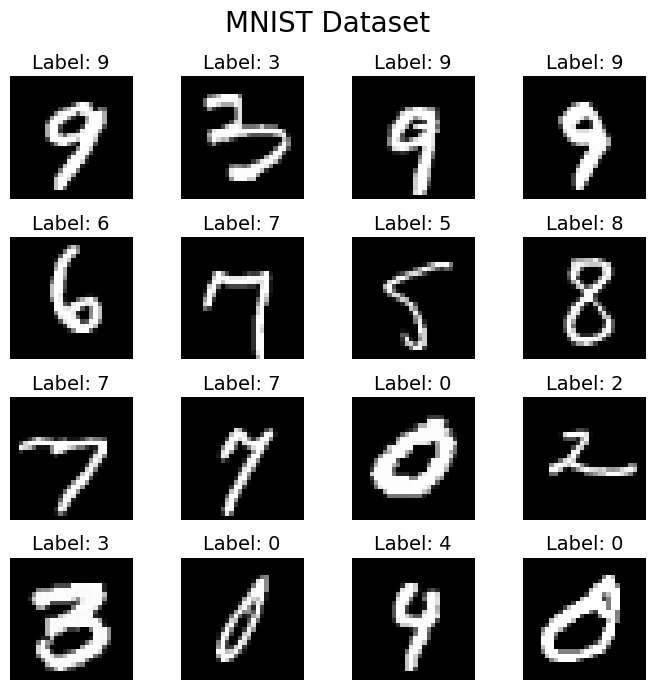

In [5]:
mnist.dataset_visualization()

In [6]:
# 이후 편의를 위해 데이터셋을 변수로 할당
X_train = mnist.X_train
y_train = mnist.y_train
X_valid = mnist.X_valid
y_valid = mnist.y_valid
X_test = mnist.X_test
y_test = mnist.y_test